# Population Simulation: Type 1 Diabetes
Timothy Novak and Maia Materman

Modeling and Simulation of the Physical World: Project 1: Population

September 2018

# General Population Model
The following selection of code creates a standard population model which models world population growth based on known census data. This model serves primarily as a reference for what the entire class, Modeling and Simulation of the Physical World, has completed up to this point. The model also serves to inform the Type 1 Diabetes model with an estimated population growth rate.

Saving figure to file World_Population_Logistic_Growth_Model.pdf


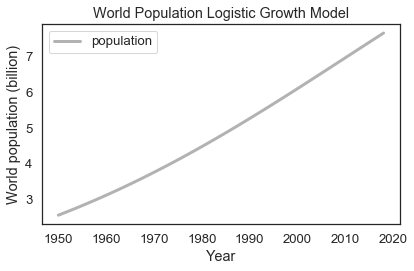

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import code libraries
from modsim import *
import random
import math
from pandas import read_html

#A function which runs a simulation of population growth.
#This function takes in a system of innital values, and a function which will update the curent state of the model from one time step to the next.
#this function returns a time series where each entry is the world population at a given time.
def run_population_growth_simulation(system, update_func):

    #configures the time series which will be returned and sets the inital value.
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    #loops through all the time steps in the simulation
    for t in linrange(system.t_0, system.t_end):
        
        #runs a step of the simulation and appends the total world population to the return values
        results[t+1] = update_func(results[t], t, system)
        
    #returns the results of the simulation
    return results

#this is a function which simulates one time step of a logistic population model
#it takes arguments of the current population, current time, and system of model parameters
#it returns the new population
def update_func_logistic(pop, t, system):

    #calculates the growth in the population between two time steps
    net_growth = system.alpha * pop + system.beta * pop**2
    
    #returns the new population
    return pop + net_growth

#declares the system of model parameters
population_growth_system = System(t_0=1950, 
                t_end=2018,
                p_0=2.557628654,
                alpha=0.025,
                beta=-0.0018)

#runs a simulation of the population
population_growth_results = run_population_growth_simulation(population_growth_system, update_func_logistic)

#plots the results
plot(population_growth_results, color='gray', label = "population")
    
#Adds labels to the graph
decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title="World Population Logistic Growth Model")

#saves the figure to a file on the computer
savefig('World_Population_Logistic_Growth_Model.pdf')

### Motivating Question for Diabetes Model:
The requirements of the class project explained that the model must deal with population and perform meaningful work. We found that Type 1 Diabetes propagation in a population would be interesting to study. Recently there has been an uptrend, of unknown cause, in the proportion of the population which has Type 1 Diabetes. This model serves to investigate whether genetic propagation of the disorder is suficent to explain the observed behavior.

### Initial Conditions and System Variable Set Up
We first need to look at initial conditions and system inputs.

In [34]:
#Initialize System with various transmission rates and initial populations of type 1 diabetics, carrying and neutral individuals
system = System(initpop = 6236068, safe_pop_rate =.9653 , carry_pop_rate =.0345, sick_pop_rate = .0002, death_rate = .0074)
state = State(year = 2018)
#create 2d array of transmission rates
#the output array is as follows
#   MM  Mm  mm
#FF.01 .01 .10
#Ff.01 .02 .10
#ff.04 .04 .14
transmission_rates = [[.01,.01,.1],[.01,.02,.1],[.04,.04,.14]]

[[0.01, 0.01, 0.1], [0.01, 0.02, 0.1], [0.04, 0.04, 0.14]]

### Setting Up the Initial Populations
We will take the each of the initial populations of the group and divide them into two groups on the basis of sex. One is made to represent males and the other is made to represent females. Interestingly enough, the propagation rates of the disorder vary by sex of the parents.

We will now assign each human one of three states:

0: A person who does not have any of the transmission genes 

1: A person who is a carrier of the disorder but does not have it 

2: A person who has the disorder

In [35]:
#create arrays of people
female = []
male = []
people_per_array_person = 1000
#divide relative populations by two to find the number of males and females for each group then divide by 100,000 so that each person in the array is representative of 100,000 people
# print("initpop: ", system.initpop)
# print("sick rate = ", system.sick_pop_rate)
healthy = math.ceil((system.initpop * system.safe_pop_rate)/2/people_per_array_person)
carrier = math.ceil((system.initpop* system.carry_pop_rate)/2/people_per_array_person)
sick = math.ceil((system.initpop* system.sick_pop_rate)/2/people_per_array_person)
# print("HCS: ", healthy, carrier, sick)
for i in range(healthy):
    female.append(0)
    male.append(0)
for j in range(carrier):
    female.append(1)
    male.append(1)
for k in range(sick):
    female.append(2)
    male.append(2)

It is important to note that to conserve memory and time when running simulations, each 'person' in the arrays is representative of 1000 people.
When we start accounting for deaths, it will be important that the arrays are randomized.

In [36]:
#scramble the arrays
random.shuffle(female)
random.shuffle(male)

### Breeding Algorithm
For each time step we will need to breed our population. For this reason, we need to create a breeding algorithm. We will assume that each male has an equal chance of being paired with any female. So we will start by picking a random male and a random female.

In [37]:
#generate a random male and a random female
randommale = male[random.randint(0,len(male))]
randomfemale = female[random.randint(0,len(female))]

0

Now, we will mate the individuals. We assume that one person will be formed from every couple. We then use the flip function to determine whether the child has the disorder, is a carrier, or has no relation to the disorder. We found the values which we put in our flip function from research on type 1 diabetes. We also assume that there is an equal probability of the child being either male or female.

In [38]:
#generate a child and assign a trait to it and append it to the relevant array
# print(female,male)
child = 0
#apply transmission rates
if flip(transmission_rates[randomfemale][randommale]):
    child = 2
elif flip(system.carry_pop_rate):
    child = 1
else:
    child = 0
#assign sex
if flip(.5):
    female.append(child)
else:
    male.append(child)

That breeding function is the heart of our model. At this point, it makes sense to encapsulate it into a mate function.

In [39]:
#encapsulate the code above into a function
def mate (system, state, male, female, transmission_rates):
    "This function performs a random mating algorithm which mates one male and one female. It takes a system variable which stores percent carrying rate for a genitic disorder. male and female are arrays which store the population of males and females in the simulation. Transmission rates is a 3X3 matrix which holds the relative propagation rates of various pairings of parents"
    #generate a random male and a random female
    randommale = male[random.randint(0,len(male)-1)]
    randomfemale = female[random.randint(0,len(female)-1)]
    #generate a child and assign a trait to it and append it to the relevant array
    
    child = 0
    #apply the transmission rates
    if flip(transmission_rates[randomfemale][randommale]):
        child = 2
    elif flip(system.carry_pop_rate):
        child = 1
    else:
        child = 0
    #make sex
    if flip(.5):
        female.append(child)
    else:
        male.append(child)
   # print (female)
    #print (male)
    
#mate (system, state, male, female, transmission_rates)

### Time Step
Now we can start making our update function that gets run every time step. At the start of our time step we want to generate a number of babies which correlates to the growth rate of the population.

In [40]:
growthrate = .01
#make a loop which generates a number of kids by running it in proportion to the growthrate + death rate
for growthcounter in range(math.ceil((growthrate + system.death_rate)*(len(male)+len(female)))):
    
    #perform breeding algorithm
    mate (system, state, male, female, transmission_rates)


Before we go on, it is important to note that in the previous code, we generate children equal to the growth rate + the death rate because the growth rate is actually the net growth rate (living people - dead people). This is necessary to consider when we make new people.

Although this seems good, it falls into the problem that our very first model of population this semester fell into: it assumes a constant growth rate. For this reason, we need to write another function which retrieves a growth rate.

In [47]:
#Growth rate retrieval function
def retrieverate(year, results, population_growth_system):
    "this model takes in the results from the original population model and the curent year and will return the net growth rate between the supplied year and the previous year."
    #checks if it is the first year in the series
    if year == population_growth_system.t_0 or year > population_growth_system.t_end:
        #returns a null condition that signifies that an invalid year was inputted
         return 0
    #if it is a valid year
    elif year <= population_growth_system.t_end:
        #returns the net growth from the previous year
        #print("Growth rate:", (results[year]- results[year-1])/results[year-1])
        return ((results[year]- results[year-1])/results[year-1])
    else:
        return 0
   

Now that we are here, there is just one more idea we need to account for in our time step: the fact that people that die off. We need to kill off people in the population according to what the death rate predicts.

In [42]:
#loops through the death rate
for deathcounter in range(math.ceil(system.death_rate*(len(female)+len(male)))):
    #if the member to be deleted is one with type 1 diabetes
    if flip(.5):
        del female[0]
    else:
        del male[0]

You might notice that we are handling these deaths in an odd way, by explicitly killing off the people from the begining of the array. This is because it creates population turn over. New babies are added to one end of the array and the other end of the array has the old die off. This then means that as a baby gets older it will get cycled through the array until it dies at the other end.This keeps the population from becoming stagnant when the growth rate lessens towards the carrying capacity.

Well we can now calculate the percent of the population which has the disorder by dividing the number of diabetic individuals by the total population found as the sum of the male and female arrays. We can also encapsulate the function at the end of this into an update function.

In [43]:
#makes the percent population calculation and print it

def num_sick(male,female):
    sickcounter = 0
    total = 0
    for malecounter in male:
        total += 1
        if malecounter == 2:
            sickcounter +=1
    for femalecounter in female:
        total += 1
        if femalecounter == 2:
            sickcounter += 1
    #print(total, len(male), len(female), sickcounter)
    return sickcounter
        

#Encapsulates everything into an update function
def update(system, state, year, population_growth_system, population_growth_results, male, female, transmission_rates):
    gr = retrieverate(year, population_growth_results, population_growth_system)
    #print("GR: ", gr)
    for r in range(0, (math.ceil((gr + system.death_rate) * (len(male))))):
        mate(system, state, male, female, transmission_rates)
            
    for deathcounter in range(math.ceil(system.death_rate*(len(female)+len(male)))):
        #if the member to be deleted is one with type 1 diabetes
        if flip(.5):
            del female[0]
        else:
            del male[0]
    state.year = year +1
    #print("Num sick:", num_sick(male, female))
    return (num_sick(male,female)/(len(female)+len(male)))

### Run simulation
We can now make a pretty standard run simulation function which retuns a time series of percent populations

In [44]:
#Run simulation function which retuns a time series
def run_genetic_disorder_sim(start_year, end_year, init_local_population):
    #creates a system which holds the values for the global population
    population_growth_system = System(t_0=start_year, 
                                      t_end=end_year,
                                      p_0=2.557628654,
                                      alpha=0.025,
                                      beta=-0.0018)
    #generates the population growth model for the entire population
    population_growth_results = run_population_growth_simulation(population_growth_system, update_func_quad)
    
    #Initialize System with various transmission percentages and initial populations of type 1 diabetics, carrying and neutral individuals
    genetic_system = System(initpop = init_local_population, safe_pop_rate =.92 , carry_pop_rate =.05, sick_pop_rate = .03, death_rate = .0074)
    genetic_state = State(sickcounter = 0, year = start_year)
    #create 2d array of transmission rates
    #the output array is as follows
    #   MM  Mm  mm
    #FF.01 .02 .10
    #Ff.02 .04 .20
    #ff.04 .08 .40
    transmission_rates = [[.01,.02,.1],[.02,.04,.2],[.04,.08,.40]]
    
    #create arrays of people
    female = []
    male = []
    people_per_array_person = 100000
    #divide relative populations by two to find the number of males and females for each group then divide by 100,000 so that each person in the array is representative of 100,000 people
    healthy = int((genetic_system.initpop * genetic_system.safe_pop_rate)/2/people_per_array_person)
    carrier = int((genetic_system.initpop* genetic_system.carry_pop_rate)/2/people_per_array_person)
    sick = int((genetic_system.initpop* genetic_system.sick_pop_rate)/2/people_per_array_person)
    #print ("HCS: ", healthy, carrier, sick)
    for i in range(healthy):
        female.append(0)
        male.append(0)
    for j in range(carrier):
        female.append(1)
        male.append(1)
    for k in range(sick):
        female.append(2)
        male.append(2)
        
    population_with_disorder_rate = TimeSeries()
    #print(num_sick(male,female)/(len(male)+len(female)))
    for t in linrange(genetic_state.year, population_growth_system.t_end, 1):
        population_with_disorder_rate[t] = update(genetic_system, genetic_state,t, population_growth_system, population_growth_results, male, female, transmission_rates)
    #print(percent_population_with_disorder[population_growth_system.t_0])
    return population_with_disorder_rate

### Results
We can now get some results. We can plot the percent population which is diabetic over time.

Saving figure to file diabetic_percent.pdf


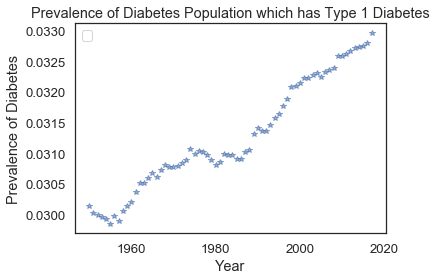

In [45]:
#Plots of percent diabetic over time
plot(run_genetic_disorder_sim(1950, 2018, 2557628654),"*")
decorate(title = "Prevalence of Diabetes Population which has Type 1 Diabetes", xlabel = "Year", ylabel= "Prevalence of Diabetes")
savefig('diabetic_percent.pdf')

This model uses the global population.

### Interpretation
Let's answer our motivating question!
Is a genetic propagation model sufficent to explain the propagation of type 1 diabetes in the population?

No.

We can see this from a few sections of the graph. For one, the significant drop at the beginning of the graph demonstrates that an exclusively genetic model is insufficent to explain the increase diabetics occuring in the world today. On top of that, the percent of the population with Type 1 Diabetes increases by less than a percentage. The fact that this rate is not increasing by around 2% percent annually illustrates how inadequate the model is for modern trends.